In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns

import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Normalization
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping



from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MaxAbsScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
dataset = '/Users/kieran/Desktop/Le Wag/train1_update.csv'
df = pd.read_csv(dataset)
display(df)

,id,cycle,setting1,setting2,T24_Total_temperature_at_LPC_outlet,T30_Total_temperature_at_HPC_outlet,T50_Total_temperature_at_LPT_outlet,P30_Total_pressure_at_HPC_outlet,Nf_Physical_fan_speed,Nc_Physical_core_speed,Ps30_Static_pressure_at_HPC_outlet,phi_Ratio_of_fuel_flow_to_Ps30,NRf_Corrected_fan_speed,NRc_Corrected_core_speed,BPR_Bypass_Ratio,htBleed_Bleed_Enthalpy,W31_HPT_coolant_bleed,W32_LPT_coolant_bleed,RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,100,198,0.0004,0.0000,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [3]:
features = df.drop(['id', 'cycle', 'RUL'], axis=1)
target = df['RUL']

In [4]:
scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)


In [6]:
    def create_sequences(df, features, target, cycle_length, sequence_count):
        sequences = []
        rul_values = []

        for engine_id in df['id'].unique():
            engine_data = features[df['id'] == engine_id]
            engine_rul = target[df['id'] == engine_id]

            for i in range(0, len(engine_data) - cycle_length * sequence_count + 1, cycle_length):
                seq = []
                for j in range(sequence_count):
                    seq.append(engine_data[i + j * cycle_length : i + (j + 1) * cycle_length])
                sequences.append(np.concatenate(seq))
                rul_values.append(engine_rul.iloc[i + cycle_length * sequence_count - 1])

        return np.array(sequences), np.array(rul_values)

Using MinMaxScaler
Using StandardScaler
Using RobustScaler
Using MaxAbsScaler


In [7]:
cycle_length = 30
sequence_count = 1
sequences, rul_values = create_sequences(df, features_norm, target, cycle_length, sequence_count)

In [8]:
split_ratio = 0.8
split_index = int(len(sequences) * split_ratio)

X_train, X_test = sequences[:split_index], sequences[split_index:]
y_train, y_test = rul_values[:split_index], rul_values[split_index:]


In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((514, 30, 16), (129, 30, 16), (514,), (129,))

In [10]:
normalizer = Normalization()
normalizer.adapt(X_train)

In [16]:


def build_rnn_model(input_shape):

    model = Sequential()
    model.add(normalizer)
    model.add(LSTM(units=200, return_sequences=True))
    model.add(Dropout(0.05))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.05))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.05))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.05))
    model.add(Dense(1, activation='linear'))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


    # model.compile(loss='mse', 
    #           optimizer='rmsprop',
    #          metrics=['mae', 'accuracy'])

    # model.compile(optimizer='adam', loss=tf.keras.losses.Huber())
    # return model


input_shape = (cycle_length * sequence_count, features.shape[1])
model = build_rnn_model(input_shape)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 30, 16)         │            33 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33 (136.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 33 (136.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [18]:
history = model.fit(X_train, y_train, validation_split=0.2, batch_size=16, epochs=500, callbacks=[early_stopping], verbose=1)

Epoch 1/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 13605.3281 - mae: 98.8963 - val_loss: 12072.3018 - val_mae: 89.0251
Epoch 2/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8792.7148 - mae: 76.2230 - val_loss: 5314.6104 - val_mae: 53.6010
Epoch 3/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3233.0859 - mae: 44.1775 - val_loss: 2928.6814 - val_mae: 40.8762
Epoch 4/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2756.0671 - mae: 41.9033 - val_loss: 3032.2490 - val_mae: 40.7850
Epoch 5/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2501.7976 - mae: 38.1983 - val_loss: 3008.6033 - val_mae: 40.6282
Epoch 6/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2465.5247 - mae: 38.7892 - val_loss: 2965.8713 - val_mae: 40.4119
Epoch 7/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 2536.0286 - mae: 39.3993 - val_loss: 4207.1284 - val_mae: 50.3740
Epoch 8/500
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2532.4326 - mae: 39.1549 - val_loss: 3898.3979 - val_mae

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2041.5208 - mae: 32.3217 
Test Loss: [2144.4638671875, 32.97151565551758]
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Mean Absolute Error (MAE): 32.97151812841726
Mean Squared Error (MSE): 2144.463816232906
Root Mean Squared Error (RMSE): 46.30835579280381


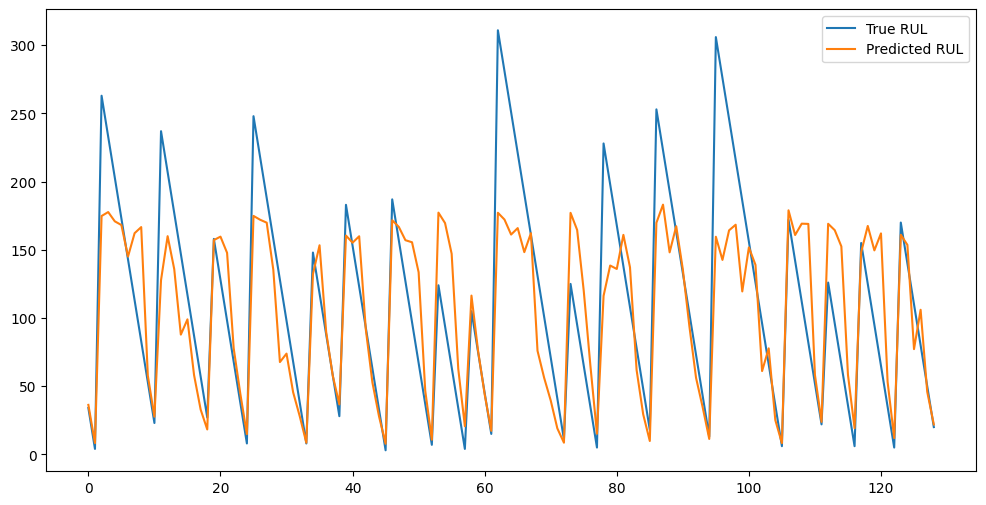

In [19]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# Compute additional metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Compare predictions to the actual values
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True RUL')
plt.plot(predictions, label='Predicted RUL')
plt.legend()
plt.show()